In [2]:
import xgboost as xgb
import sys, os
sys.path.append(os.path.abspath('..'))
from ift6758.data.feature_engineering_one import feature_engineering_one
from ift6758.data.feature_engineering_pt2  import feature_engineering_two
import ift6758.data.advanced_models as adv

In [3]:
df = feature_engineering_one(years = range(2016, 2019))
df.head(10)

100%|██████████| 4030/4030 [01:07<00:00, 59.93it/s]


,game_id,season,game_time,period,period_time,event_type,team_id,team_name,coordinates_x,coordinates_y,...,goalie,shot_type,empty_net,strength,situation_code,zone_code,distance_to_net,shot_angle,is_goal,is_empty_net
0,2016020001,20162017,2016-10-12 23:00:00+00:00,1,01:11,shot,10,Maple Leafs,-77.0,5.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,13.000000,-1.725255,0,0
1,2016020001,20162017,2016-10-12 23:00:00+00:00,1,02:53,shot,9,Senators,86.0,13.0,...,Frederik Andersen,wrist,False,Even Strength,1551,O,13.341664,-77.005383,0,0
2,2016020001,20162017,2016-10-12 23:00:00+00:00,1,04:01,shot,9,Senators,23.0,-38.0,...,Frederik Andersen,wrist,False,Even Strength,1551,N,76.157731,29.931512,0,0
3,2016020001,20162017,2016-10-12 23:00:00+00:00,1,04:46,shot,9,Senators,33.0,-15.0,...,Frederik Andersen,slap,False,Even Strength,1551,O,57.974132,14.995079,0,0
4,2016020001,20162017,2016-10-12 23:00:00+00:00,1,06:46,shot,10,Maple Leafs,-34.0,28.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,61.717096,-12.824398,0,0
5,2016020001,20162017,2016-10-12 23:00:00+00:00,1,07:30,shot,10,Maple Leafs,-33.0,-17.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,58.523500,7.932758,0,0
6,2016020001,20162017,2016-10-12 23:00:00+00:00,1,08:21,goal,10,Maple Leafs,-70.0,1.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,19.026298,-0.360346,1,0
7,2016020001,20162017,2016-10-12 23:00:00+00:00,1,08:29,shot,10,Maple Leafs,-45.0,-36.0,...,Craig Anderson,wrist,False,Even Strength,1551,O,56.850682,15.037816,0,0
8,2016020001,20162017,2016-10-12 23:00:00+00:00,1,09:00,shot,9,Senators,33.0,-18.0,...,Frederik Andersen,slap,False,Even Strength,1551,O,58.821765,17.818889,0,0
9,2016020001,20162017,2016-10-12 23:00:00+00:00,1,10:16,shot,9,Senators,34.0,20.0,...,Frederik Andersen,wrist,False,Even Strength,1551,O,58.523500,-19.983107,0,0


In [4]:
from sklearn.model_selection import train_test_split 

X = df[['distance_to_net', 'shot_angle']]
y = df['is_goal']

X_train, X_val, y_train, y_val = train_test_split(
  X, y, test_size=0.2, random_state=42
)

xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict_proba(X_val)[:, 1]

c:\Users\Goofy\miniconda3\envs\ift-ml\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:47:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


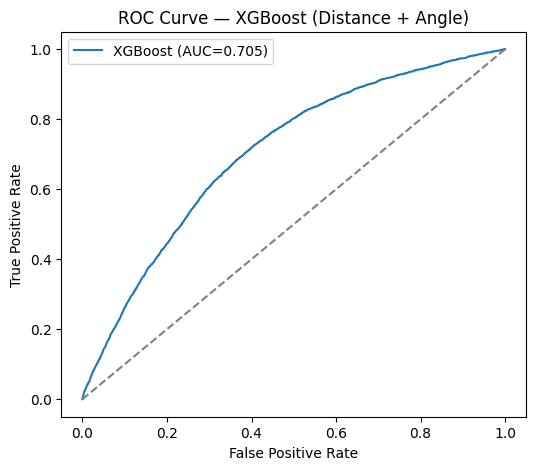

In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

fpr, tpr, _ = roc_curve(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGBoost (AUC={auc:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost (Distance + Angle)")
plt.legend()
plt.show()

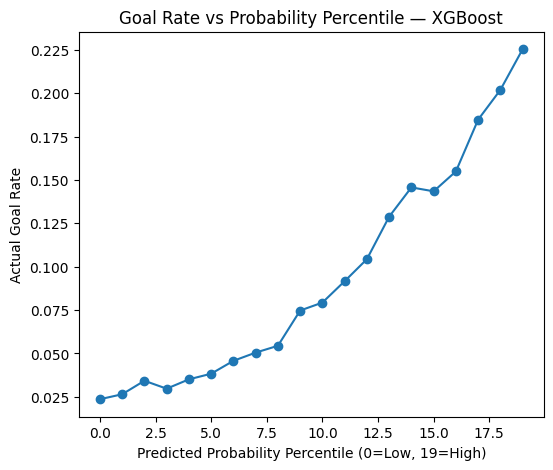

In [6]:
df_val = pd.DataFrame({"y_true": y_val, "y_pred": y_pred})
df_val["percentile"] = pd.qcut(df_val["y_pred"], 20, labels=False)

goal_rate = df_val.groupby("percentile")["y_true"].mean()
plt.figure(figsize=(6,5))
plt.plot(goal_rate.index, goal_rate.values, marker="o")
plt.xlabel("Predicted Probability Percentile (0=Low, 19=High)")
plt.ylabel("Actual Goal Rate")
plt.title("Goal Rate vs Probability Percentile — XGBoost")
plt.show()

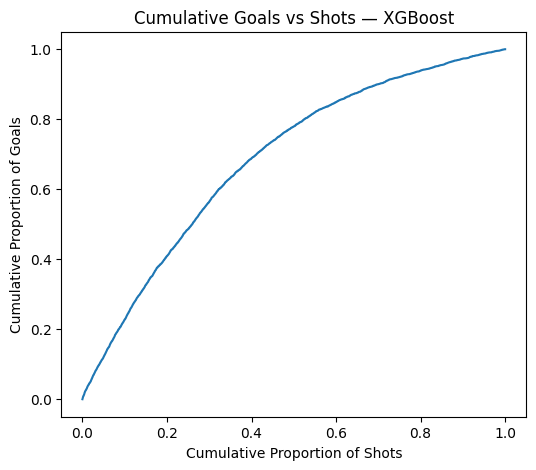

In [7]:
df_sorted = df_val.sort_values("y_pred", ascending=False)
df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
df_sorted["cum_goals_prop"] = df_sorted["cum_goals"] / df_sorted["y_true"].sum()
df_sorted["cum_shots_prop"] = np.arange(1, len(df_sorted)+1) / len(df_sorted)

plt.figure(figsize=(6,5))
plt.plot(df_sorted["cum_shots_prop"], df_sorted["cum_goals_prop"])
plt.xlabel("Cumulative Proportion of Shots")
plt.ylabel("Cumulative Proportion of Goals")
plt.title("Cumulative Goals vs Shots — XGBoost")
plt.show()

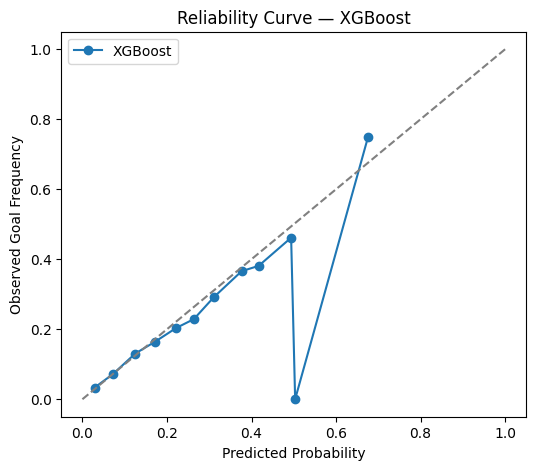

In [8]:
prob_true, prob_pred = calibration_curve(y_val, y_pred, n_bins=20)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label="XGBoost")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Goal Frequency")
plt.title("Reliability Curve — XGBoost")
plt.legend()
plt.show()

In [9]:
df2 = feature_engineering_two( years = range(2016, 2019))


In [10]:
df2.describe()

,game_id,season,period,team_id,coordinates_x,coordinates_y,situation_code,previous_event_x,previous_event_y,friendly_skaters,...,current_event_timeseconds,previous_event_timeseconds,time_since_last_event,distance_from_last_event,angle_shot_prev,angle_shot,speed,angle_change,distance_shot,is_goal
count,2.534750e+05,2.534750e+05,253475.000000,253475.000000,253460.000000,253461.000000,253475.000000,241866.000000,241868.000000,253475.000000,...,253475.000000,253475.000000,253475.000000,241855.000000,253471.000000,253459.000000,237865.000000,253467.000000,253459.000000,253475.00000
mean,2.017043e+09,2.017224e+07,2.046612,18.513976,-0.048935,0.093273,1518.691378,0.061489,0.143690,4.922797,...,590.514552,576.164099,14.350453,63.517943,4.983406,18.615099,6.890609,7.185985,33.867716,0.09395
std,8.097828e+05,8.098682e+03,0.875505,13.454248,63.580887,18.985107,138.723295,64.899773,23.228446,0.469856,...,350.220626,350.218705,27.892961,46.725436,13.003930,19.493151,9.976855,18.081017,18.946031,0.29176
min,2.016020e+09,2.016202e+07,1.000000,1.000000,-99.000000,-42.000000,101.000000,-99.000000,-42.000000,1.000000,...,0.000000,0.000000,-1195.000000,0.000000,0.000000,0.000000,-187.523332,0.000000,0.000000,0.00000
25%,2.016021e+09,2.016202e+07,1.000000,8.000000,-64.000000,-14.000000,1551.000000,-69.000000,-22.000000,5.000000,...,284.000000,269.000000,5.000000,27.018512,0.000000,4.007805,1.879880,0.000000,17.000000,0.00000
50%,2.017021e+09,2.017202e+07,2.000000,17.000000,-3.000000,0.000000,1551.000000,0.000000,0.000000,5.000000,...,582.000000,568.000000,11.000000,48.083261,0.000000,10.992508,4.288946,0.000000,32.557641,0.00000
75%,2.018020e+09,2.018202e+07,3.000000,25.000000,64.000000,14.000000,1551.000000,69.000000,22.000000,5.000000,...,894.000000,879.000000,21.000000,97.005155,1.023030,28.495639,9.152896,1.674838,48.270074,0.00000
max,2.018030e+09,2.018202e+07,5.000000,54.000000,99.000000,42.000000,1560.000000,99.000000,42.000000,6.000000,...,1200.000000,1200.000000,1085.000000,201.109423,90.000000,90.000000,186.625293,177.954592,97.989795,1.00000


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import xgboost as xgb

X = df2[['game_time', 'period','period_time', 'coordinates_x','coordinates_y',
         'distance_shot', 'angle_shot','shot_type','previous_event_name',
         'previous_event_timeperiod','friendly_skaters','opponent_skaters','previous_event_timeseconds',
         'previous_event_x','previous_event_y','distance_from_last_event',
         'rebound','angle_change','speed']]
X = X.copy()
X['rebound'] = X['rebound'].astype(int)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['number']).columns
median_values = X[numerical_cols].median()

X.loc[:, numerical_cols] = X[numerical_cols].fillna(median_values)
X.loc[:, categorical_cols] = X[categorical_cols].fillna('Unknown')

#change the game_time to second format
X = adv._calculate_time_second(X)
#change the period_time to second format
X = adv._calculate_period_second(X)

X = X.drop(columns=['game_time', 'period_time', 'previous_event_timeperiod'])

y = (df2['event_type'] == 'goal').astype(int)



In [12]:


X_train2, X_val2, y_train2, y_val2 = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Standardize the numeric columns
exclude_cols = ['shot_type', 'previous_event_name','rebound']
num_cols = [
    col for col in X_train2.columns
    if col not in exclude_cols and X_train2[col].dtype in ['float64', 'int64']
]
scaler = StandardScaler()
X_train2[num_cols] = scaler.fit_transform(X_train2[num_cols])
X_val2[num_cols] = scaler.transform(X_val2[num_cols])
X_train2, ohe = adv.change_to_one_hot(X_train2, ['shot_type', 'previous_event_name'], ohe=None)
X_val2, _ = adv.change_to_one_hot(X_val2, ['shot_type', 'previous_event_name'], ohe=ohe)
X_train2.head(10)

,period,coordinates_x,coordinates_y,distance_shot,angle_shot,friendly_skaters,opponent_skaters,previous_event_timeseconds,previous_event_x,previous_event_y,...,previous_event_name_giveaway,previous_event_name_goal,previous_event_name_hit,previous_event_name_missed-shot,previous_event_name_penalty,previous_event_name_period-end,previous_event_name_period-start,previous_event_name_shot-on-goal,previous_event_name_stoppage,previous_event_name_takeaway
17006,-0.053662,0.582492,1.679621,1.432915,0.665744,0.164325,0.361880,699,0.566449,1.451032,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40406,-1.196334,0.645431,-0.320308,0.763625,-0.589362,0.164325,0.361880,577,1.291951,-1.018099,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59945,-0.053662,-1.116860,-0.951864,-0.445681,-0.625567,0.164325,-1.301132,1069,-1.010729,-0.753550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3086,-1.196334,-1.038187,1.048064,-0.180596,-0.577706,0.164325,0.361880,1032,-1.452339,-0.841733,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
217262,-0.053662,-1.132595,0.679656,-0.659648,-0.717970,0.164325,0.361880,261,-0.616434,1.274665,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58343,-1.196334,1.086004,1.521732,0.069960,1.885873,0.164325,0.361880,16,-0.206368,-0.092175,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108631,-0.053662,-1.038187,-0.162419,-0.564989,-0.897786,0.164325,0.361880,603,-1.058044,0.172375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12624,1.089009,-1.289943,1.416472,-0.317097,-0.494644,2.297199,0.361880,1069,-1.073816,0.921932,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69063,-1.196334,-1.305677,-0.004530,-1.472314,-0.954629,0.164325,0.361880,594,-0.001335,-0.003992,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
114726,-1.196334,-1.006717,-0.057159,-0.468680,-0.935432,-1.968549,0.361880,1045,0.361416,0.172375,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:

param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [1, 3, 5],
    'reg_alpha': [0, 0.5, 1]
}

xgb_base = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight = len(y[y==0]) / len(y[y==1])
)

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='roc_auc',
    random_state=42
)

search.fit(X_train2, y_train2)

#evaluate the model
best_model = search.best_estimator_
y_pred_proba = best_model.predict_proba(X_val2)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("Best params:", search.best_params_)
print("Best CV AUC:", search.best_score_)
print("Validation AUC:", roc_auc_score(y_val2, y_pred_proba))
print("Validation F1:", f1_score(y_val2, y_pred))
print("Validation Acc:", accuracy_score(y_val2, y_pred))


Best params: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV AUC: 0.7840585726927135
Validation AUC: 0.783026164758906
Validation F1: 0.3091981647367271
Validation Acc: 0.688154650359996


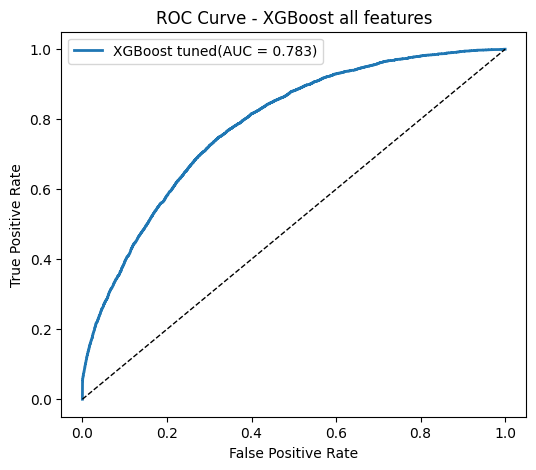

In [14]:

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import pandas as pd

#ROC Curve
fpr, tpr, _ = roc_curve(y_val2, y_pred_proba)
roc_auc = roc_auc_score(y_val2, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost tuned(AUC = {roc_auc:.3f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost all features")
plt.legend()
plt.show()

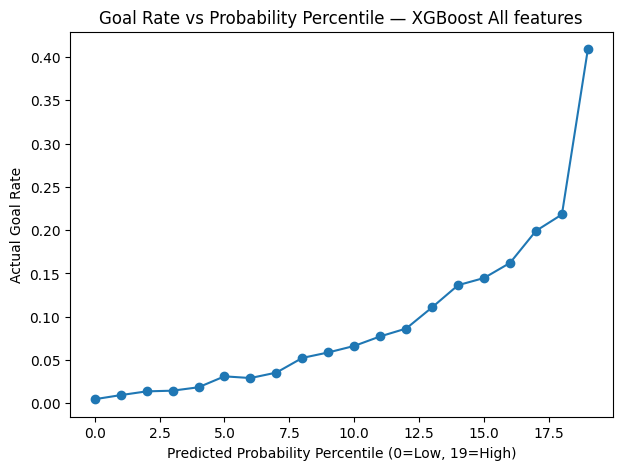

In [15]:
#Goal rate vs probability percentile
df_val = pd.DataFrame({"y_true": y_val2, "y_pred": y_pred_proba})
df_val["percentile"] = pd.qcut(df_val["y_pred"], 20, labels=False)

goal_rate = df_val.groupby("percentile")["y_true"].mean()
plt.figure(figsize=(7,5))
plt.plot(goal_rate.index, goal_rate.values, marker="o")
plt.xlabel("Predicted Probability Percentile (0=Low, 19=High)")
plt.ylabel("Actual Goal Rate")
plt.title("Goal Rate vs Probability Percentile — XGBoost All features")
plt.show()

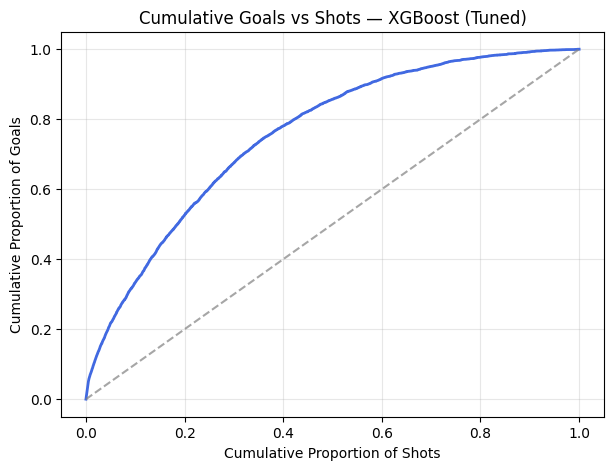

In [16]:
#Cumulative proportion of goals vs probability percentile
import numpy as np
import matplotlib.pyplot as plt

df_sorted = df_val.sort_values("y_pred", ascending=False).reset_index(drop=True)
df_sorted["cum_goals"] = df_sorted["y_true"].cumsum()
df_sorted["cum_goals_prop"] = df_sorted["cum_goals"] / df_sorted["y_true"].sum()
df_sorted["cum_shots_prop"] = (np.arange(1, len(df_sorted) + 1)) / len(df_sorted)

plt.figure(figsize=(7, 5))
plt.plot(df_sorted["cum_shots_prop"], df_sorted["cum_goals_prop"], color='royalblue', linewidth=2)
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.7) 
plt.xlabel("Cumulative Proportion of Shots")
plt.ylabel("Cumulative Proportion of Goals")
plt.title("Cumulative Goals vs Shots — XGBoost (Tuned)")
plt.grid(True, alpha=0.3)
plt.show()


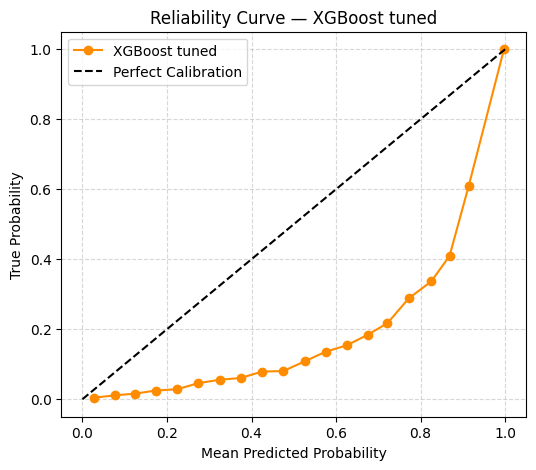

In [17]:
# Reliability curve
prob_true, prob_pred = calibration_curve(y_val2, y_pred_proba, n_bins=20)

plt.figure(figsize=(6, 5))
plt.plot(prob_pred, prob_true, "o-", color="darkorange", label="XGBoost tuned")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("True Probability")
plt.title("Reliability Curve — XGBoost tuned")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [18]:
# to find if two features are highly correlated
import numpy as np
numeric_features = X_train2.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr()
threshold = 0.8
corr_pairs = corr_matrix.unstack()
high_corr = corr_pairs[(abs(corr_pairs) > threshold) & (abs(corr_pairs) < 1)]
high_corr = high_corr.sort_values(ascending=False)
print(high_corr)


previous_event_timeseconds         period_time_seconds                  0.996875
period_time_seconds                previous_event_timeseconds           0.996875
                                   previous_event_timeperiod_seconds    0.996875
previous_event_timeperiod_seconds  period_time_seconds                  0.996875
dtype: float64


In [19]:
redundant_features = [
    'previous_event_timeseconds',
    'previous_event_timeperiod_seconds'
]
X_train_selected = X_train2.drop(columns=redundant_features, errors='ignore')
X_val_selected = X_val2.drop(columns=redundant_features, errors='ignore')

best_model.fit(X_train_selected, y_train2)
y_pred_proba = best_model.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("Validation AUC:", roc_auc_score(y_val2, y_pred_proba))
print("Validation F1:", f1_score(y_val2, y_pred))
print("Validation Acc:", accuracy_score(y_val2, y_pred))


Validation AUC: 0.7832644973411753
Validation F1: 0.30810174076174685
Validation Acc: 0.6871683597987968


In [20]:
from sklearn.feature_selection import VarianceThreshold

# Apply VarianceThreshold 
selector = VarianceThreshold(threshold=0.01)  

selector.fit(X_train2)
X_train_selected = selector.transform(X_train2)
X_val_selected = selector.transform(X_val2)

selected_features = X_train2.columns[selector.get_support()]
removed_features = X_train2.columns[~selector.get_support()]

print(f"\n{len(removed_features)} low-variance features:")
print(list(removed_features))

# Convert back to DataFrame (optional, but helpful for model training)

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train2.index)
X_val_selected = pd.DataFrame(X_val_selected, columns=selected_features, index=X_val2.index)

best_model.fit(X_train_selected, y_train2)
y_pred_proba = best_model.predict_proba(X_val_selected)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("Validation AUC:", roc_auc_score(y_val2, y_pred_proba))
print("Validation F1:", f1_score(y_val2, y_pred))
print("Validation Acc:", accuracy_score(y_val2, y_pred))



6 low-variance features:
['shot_type_Unknown', 'previous_event_name_game-end', 'previous_event_name_goal', 'previous_event_name_penalty', 'previous_event_name_period-end', 'previous_event_name_period-start']
Validation AUC: 0.7822828158519448
Validation F1: 0.3078806962302108
Validation Acc: 0.6878193115691883


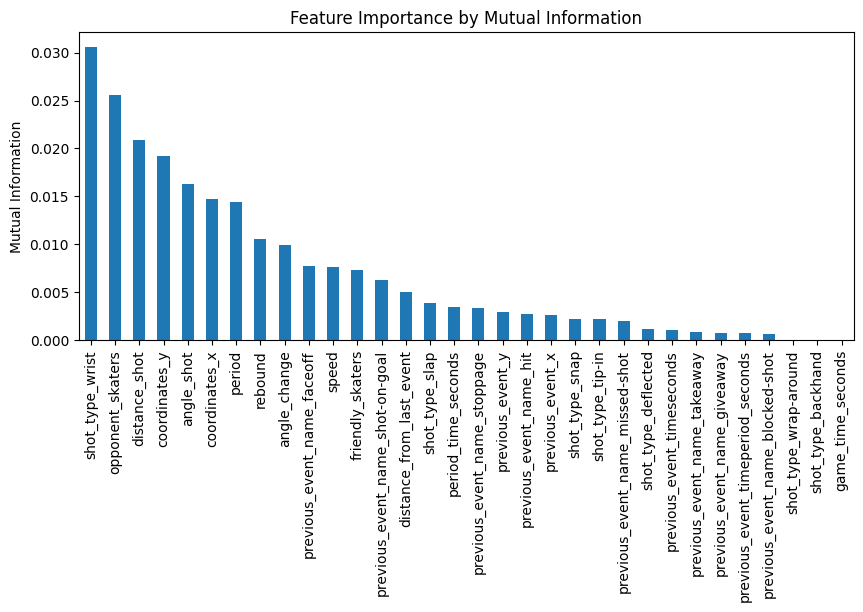

In [21]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train_selected, y_train2, discrete_features='auto')
mi_series = pd.Series(mi, index=X_train_selected.columns).sort_values(ascending=False)


mi_series.plot(kind='bar', figsize=(10,4))
plt.title("Feature Importance by Mutual Information")
plt.ylabel("Mutual Information")
plt.show()

In [22]:
low_importance_feature = ['game_time_second']

def test_feature_drop(features_to_drop):
    X_train_sel = X_train_selected.drop(columns=features_to_drop, errors='ignore')
    X_val_sel = X_val_selected.drop(columns=features_to_drop, errors='ignore')
    best_model.fit(X_train_sel, y_train2)
    y_pred_proba = best_model.predict_proba(X_val_sel)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)
    return {
        'AUC': roc_auc_score(y_val2, y_pred_proba),
        'F1': f1_score(y_val2, y_pred),
        'Acc': accuracy_score(y_val2, y_pred)
    }

# Testing the impact of a single feature
for f in low_importance_feature:
    result = test_feature_drop([f])
    print(f"{f:40s} -> AUC={result['AUC']:.4f}, F1={result['F1']:.4f}, Acc={result['Acc']:.4f}")
X_train_selected = X_train_selected.drop(columns=['game_time_seconds'], errors='ignore')
X_val_selected = X_val_selected.drop(columns=['game_time_seconds'], errors='ignore')

game_time_second                         -> AUC=0.7823, F1=0.3079, Acc=0.6878


In [23]:
#Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# use the best XGBoost model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Create the RFE selector 
selector = RFE(estimator=model, n_features_to_select=25, step=1)
selector = selector.fit(X_train2, y_train2)

selected_features = X_train2.columns[selector.support_]

X_train_sel = X_train2[selected_features]
X_val_sel = X_val2[selected_features]

model.fit(X_train_sel, y_train2)
y_pred_proba = model.predict_proba(X_val_sel)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nPerformance after RFE selection:")
print(f"AUC: {roc_auc_score(y_val2, y_pred_proba):.4f}")
print(f"F1:  {f1_score(y_val2, y_pred):.4f}")
print(f"ACC: {accuracy_score(y_val2, y_pred):.4f}")


c:\Users\Goofy\miniconda3\envs\ift-ml\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:49:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Goofy\miniconda3\envs\ift-ml\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:49:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Goofy\miniconda3\envs\ift-ml\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:49:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Goofy\miniconda3\envs\ift-ml\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:49:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "


Performance after RFE selection:
AUC: 0.7851
F1:  0.1257
ACC: 0.9108
